Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Quantum pre-processing of train images:

Quantum pre-processing of test images:


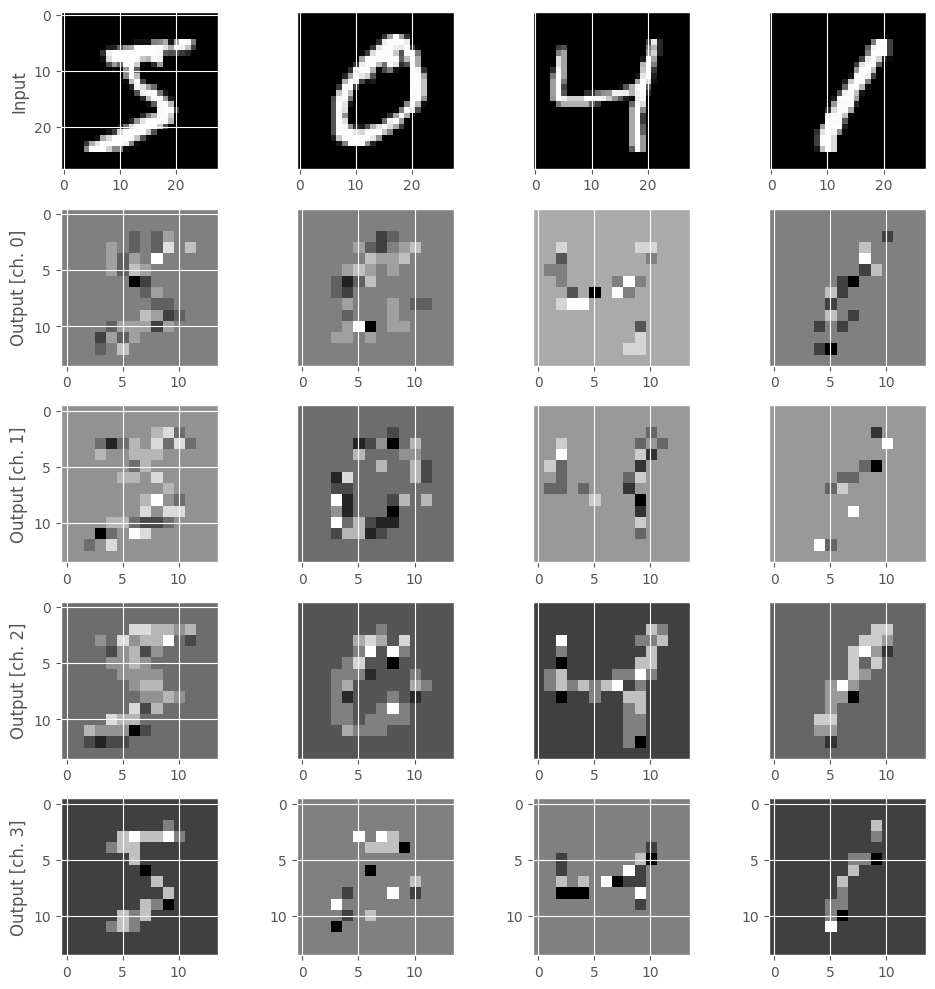

Epoch 1/30
13/13 - 1s - 72ms/step - accuracy: 0.0200 - loss: 2.4629 - val_accuracy: 0.1333 - val_loss: 2.4015
Epoch 2/30
13/13 - 0s - 12ms/step - accuracy: 0.1400 - loss: 2.2835 - val_accuracy: 0.1333 - val_loss: 2.3108
Epoch 3/30
13/13 - 0s - 22ms/step - accuracy: 0.0600 - loss: 2.2891 - val_accuracy: 0.1667 - val_loss: 2.3090
Epoch 4/30
13/13 - 0s - 10ms/step - accuracy: 0.0600 - loss: 2.3029 - val_accuracy: 0.1667 - val_loss: 2.3239
Epoch 5/30
13/13 - 0s - 11ms/step - accuracy: 0.0800 - loss: 2.3023 - val_accuracy: 0.1333 - val_loss: 2.3301
Epoch 6/30
13/13 - 0s - 11ms/step - accuracy: 0.0800 - loss: 2.2991 - val_accuracy: 0.1333 - val_loss: 2.3282
Epoch 7/30
13/13 - 0s - 10ms/step - accuracy: 0.0600 - loss: 2.2981 - val_accuracy: 0.1333 - val_loss: 2.3257
Epoch 8/30
13/13 - 0s - 13ms/step - accuracy: 0.0400 - loss: 2.2983 - val_accuracy: 0.1333 - val_loss: 2.3252
Epoch 9/30
13/13 - 0s - 23ms/step - accuracy: 0.0400 - loss: 2.2985 - val_accuracy: 0.1333 - val_loss: 2.3256
Epoch 10/3

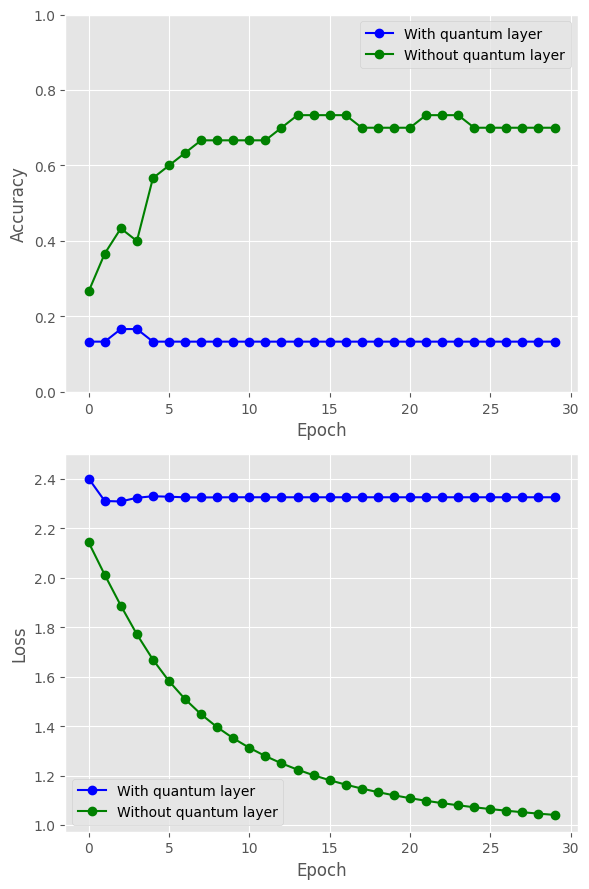

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

dev = qml.device("default.qubit", wires=4)  # 2 qubit địa chỉ + 1 qubit dữ liệu
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))


# === Superdense Encoding ===
# Superdense encoding sử dụng 2 qubit địa chỉ (index) và 2 qubit dữ liệu (data)
# Các trạng thái như |00>, |01>, |10>, |11> được chồng chập để mã hóa nhiều mẫu dữ liệu trong cùng một trạng thái lượng tử
# Sau đó, dữ liệu được ánh xạ vào các qubit dữ liệu thông qua điều khiển pha (controlled-RZ)
@qml.qnode(dev)
def circuit_superdense(patch):
    # Patch có 4 giá trị thực giữa [0, 1]
    # Biểu diễn thành 2 bit địa chỉ và 2 bit dữ liệu bằng trạng thái entangled
    for i in range(2):
        qml.Hadamard(wires=i)  # tạo trạng thái chồng chập địa chỉ |00> + |01> + |10> + |11>
    qml.CNOT(wires=[0, 2])  # truyền thông tin địa chỉ 0 -> data 2
    qml.CNOT(wires=[1, 3])  # truyền thông tin địa chỉ 1 -> data 3

    # Ánh xạ giá trị của từng ô vào pha của qubit dữ liệu tương ứng
    for i, val in enumerate(patch):
        bin_idx = format(i, '02b')
        for j, bit in enumerate(bin_idx):
            if bit == '0':
                qml.PauliX(wires=j)  # đảo bit để chọn đúng điều kiện điều khiển
        qml.ctrl(qml.RZ, control=[0, 1])(2 * np.pi * val, wires=2)  # ánh xạ giá trị vào pha của qubit dữ liệu
        for j, bit in enumerate(bin_idx):
            if bit == '0':
                qml.PauliX(wires=j)  # khôi phục lại trạng thái ban đầu

    RandomLayers(rand_params, wires=range(4))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

# === Apply quantum circuit to 2x2 patches ===
def quanv_superdense(image):
    out = np.zeros((14, 14, 4))
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            patch = image[j:j+2, k:k+2, 0].flatten()
            if patch.shape[0] == 4:
                q_results = circuit_superdense(patch)
                out[j // 2, k // 2, :] = q_results
    return out

if PREPROCESS == True:
    q_train_images_superdense_enc = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images_superdense_enc.append(quanv_superdense(img))
    q_train_images_superdense_enc = np.asarray(q_train_images_superdense_enc)

    q_test_images_superdense_enc = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images_superdense_enc.append(quanv_superdense(img))
    q_test_images_superdense_enc = np.asarray(q_test_images_superdense_enc)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images_superdense_enc.npy", q_train_images_superdense_enc)
    np.save(SAVE_PATH + "q_test_images_superdense_enc.npy", q_test_images_superdense_enc)

# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images_superdense_enc.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images_superdense_enc.npy")
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

import matplotlib.pyplot as plt
print(plt.style.available)  # In ra danh sách các style có sẵn
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()